<img src="https://images.unsplash.com/photo-1686179225818-c07909cd2911?q=80&w=2070&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="Wildfire smoke over New York City (June 7, 2023)"></img>
Photo by <a href="https://unsplash.com/@ahmerkalam?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Ahmer Kalam</a> on <a href="https://unsplash.com/photos/a-foggy-city-skyline-with-the-sun-in-the-distance-Reuk1nmutFI?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

# Visualizing Data with EPA's Air Quality System (AQS) API

---

## Overview
Air quality data are an important aspect of both atmospheric and environmental sciences. Understanding the concentrations of particulate matter and chemical species (e.g., O<sub>3</sub> and NO<sub>x</sub>) can be useful for air pollution analysis from both the physical science and health science perspectives.

The US EPA AQS has archived data that have gone through quality assurance.

In this notebook, we will cover:
1. Accessing data from the AQS
1. Exploring the format of the data
1. Preparing the data for visualization
1. Generating a timeseries plot

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html) | Necessary | How to deal with dataframes and datasets |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Skills for different plotting styles and techniques |

- **Time to learn**: 30 minutes
- **System requirements**:
    - <b>Email address</b> for AQS API access

---

## Imports


<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    <p>Here we'll import lots of stuff, but we might not end up using them all...</p>
</div>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import date
from datetime import datetime
import numpy as np
import os
import pyaqsapi as aqs

We will also set some limits to the size of data that Pandas displays, so as not to overload our screens.

In [2]:
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 10)  # Set to the number of rows you want to display
pd.set_option('display.max_columns', 10)  # Set to the number of columns you want to display

---

## Accessing Data from the AQS

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Important:</p>
    <p><b>If you have previously registered an account with the AQS</b>, now will be a good time to get that information out and <b>skip past the</b> `aqs.aqs_sign_up()` <b>step below</b>.</p>


<p><b>If not</b>, you should have an email address in mind that you'd like to use.</p>
</div>

### Register a new email with `aqs_sign_up()`

In the cell below, uncomment the code and replace '`EMAIL`' with an email address to use for API credentials.

In [3]:
# aqs.aqs_sign_up('EMAIL')

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">IMPORTANT</p>
    <p><b>Replace your email address</b> with '<b>EMAIL</b>' after you've run `aqs_sign_up()`, or <b>comment out</b> the line!</p>

<p>A <b>new API key</b> will be generated <i><b>every time</b></i> that line of code is executed!
</div>

#### Data can be pulled from the AQS in a number of different ways...
1. By Sample Site
1. By County
1. By State
1. By Lat/Lon Box
1. By Monitoring Agency
1. By Primary Quality Assurance Organization
1. By Core Based Statistical Aera (as defined by the US Census Bureau)

### Let's look at how the package deals with states...

In [4]:
# aqs.aqs_states()

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Whoops!</p>
    <p>You need to input your credentials before any of the functions will work!</p>
</div>

##### Use the `aqs_credentials()` function to input your username (email address) and access key.
<b>This is all found in the email you received when verifying your email address.</b>

If you've previously registered your address and do not have the key, you can simply generate a new key by using the `aqs_sign_up()` funtion to resubmit your email address.

*Let's also save our username and key as variables that we can easily call later.*

 -   `Comment` out the first line and `Uncomment` back in the second line in the cell below.
 -   Replace '`AQS_USERNAME`' and '`AQS_KEY`' with your credentials. We stored them as [environment variables](https://pubs.opengroup.org/onlinepubs/9699919799/basedefs/V1_chap08.html), to ensure they are kept secret while building this notebook.

In [5]:
aqs.aqs_credentials(username= os.getenv('AQS_USERNAME'), key= os.getenv('AQS_KEY'))
#aqs.aqs_credentials(username='AQS_USERNAME', key='AQS_KEY')


<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">MAKE SURE TO CLEAR VARIABLES!</p>
    Make sure to <b>clear</b> these variables <b>before</b> submitting a <b>pull request</b>! You <b>do not</b> want to <b>share your credentials</b>!
</div>

### Let's look at those states now...

In [6]:
aqs.aqs_states()

,code,value_represented
0,01,Alabama
1,02,Alaska
2,04,Arizona
3,05,Arkansas
4,06,California
...,...,...
51,66,Guam
52,72,Puerto Rico
53,78,Virgin Islands
54,80,Country Of Mexico


<b>Since states will be input via a number, let's store `aqs_states()` as a variable that we can call on later to remind ourselves of what states we need.</b>

Let's assume for now that we want to focus on New York and also save that code as variable.

In [7]:
states = aqs.aqs_states()
NY = 36

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Everything Is Currently Input Numerically</p>
    <p>It's important that we also address the fact that, currently, everything is input as a numerical value for pulling these data from the AQS with this Python package.</p>
</div>

Parameter Codes can be accessed from the EPA [here](https://aqs.epa.gov/aqsweb/documents/codetables/parameters.html), but to simplify things here are codes for a few common pollutants with defined Air Quality Index values you might be looking for...

| Pollutant | Parameter Code |
| --- | --- |
| Carbon Monoxide (CO) | 42101 |
| Nitrogen Dioxide (NO<sub>2</sub>) | 42602 |
| Ozone (O<sub>3</sub>) | 44201 |
| PM 10 (Total) | 81102 |  


Other variables that might be of interest:
| MET | Parameter Code |
| --- | --- |
| Wind Speed - Resultant (knots) | 61103 |
| Wind Direction - Resultant (deg) | 61104 |
| Outdoor Temperature (F) | 62101 |
| Average Ambient Temperature (C) | 68105 |
| Relative Humidity (%) | 62201 |
| Barometric Pressure (mbar) | 64101 |

<b>Let's also store the parameter codes as variables to make things more simple.</b>

In [8]:
CO = 42101
NO2 = 42602
O3 = 44201
PM10 = 81102

---

## Exploring the format of the data

Let's look at current O<sub>3</sub> data for New York State.

In [9]:
now = datetime.today()
year = now.year
month = now.month
day = now.day
print(year, month, day)

2024 6 21


<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    <p>The AQS does <b>not</b> have real-time data. Also, note that the above times are in <b>UTC!</b></p>
</div>

We'll subtract one day so we have the past day of data.

In [10]:
ozone = aqs.bystate.sampledata(parameter= O3, bdate = date(year=year, month=month, day = day-1), edate = date(year=year, month=month, day = day), stateFIPS=NY)

In [11]:
ozone

""


<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Oh, no!</p>
    <p>Looks like there isn't current O<sub>3</sub> data available. We must go <i>even further</i> back in time.</p>
</div>

In [12]:
ozone = aqs.bystate.sampledata(parameter= O3, bdate = date(year=year-1, month=month, day = day-1), edate = date(year=year-1, month=month, day = day), stateFIPS=NY)

In [13]:
#ozone

Great! Now we have some data. Let's look at the columns.

In [14]:
ozone.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'units_of_measure_code', 'sample_duration',
       'sample_duration_code', 'sample_frequency', 'detection_limit',
       'uncertainty', 'qualifier', 'method_type', 'method', 'method_code',
       'state', 'county', 'date_of_last_change', 'cbsa_code'],
      dtype='object')

<b>There is a lot of information in this dataset.</b>

1. Geospatial Information
    
1. Temporal Information
    
1. Sample Information
    
1. Data QA Information

We'll focus on a few from 1, 2, and 3:
    <p><b>Latitude</b> and <b>Longitude</b> can be used to plot these data over a map, which will be addressed in <i>Notebook 3 of this Cookbook</i></p>
    <p><b>Local Date</b> and <b>Time</b>, as well as <b>State</b>, <b>County</b>, and <b>Site Number</b> can be used as to isolate data for a time series.</p>
    <p><b>Units of Measure</b> will be necessary for annotations and labels.</p>
</div>

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">PAUSE</p>
    <p>We've seen how to pull the data, and we've seen that pulling current data is not possible due to the lag between sample time and quality-assurance checks.</p>
    <p>You are encouraged to check for more current data but, for now, let's look at this month's data from last year.</p>
</div>

In [15]:
start = 1
end = 30 #(Replace this value to match the appropriate "last day" of the month you are running this notebook)

In [16]:
ozone = aqs.bystate.sampledata(parameter= O3, bdate = date(year=year-1, month=month, day = start), edate = date(year=year-1, month=month, day = end), stateFIPS=NY)
#ozone

A quick check at plotting the data in its original format shows that some polishing is necessary.

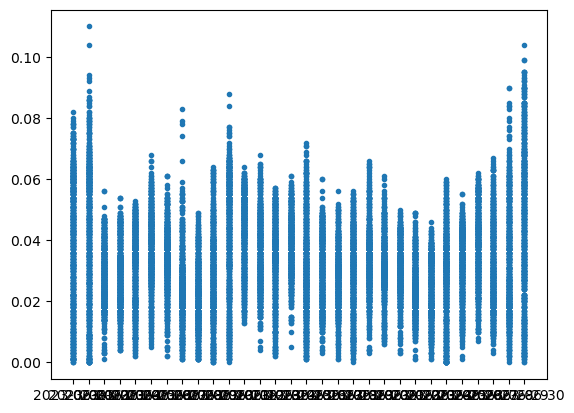

In [17]:
plt.plot(ozone['date_local'], ozone['sample_measurement'], '.')
plt.show()

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Spatiotemporal Issues Abound!</p>
    <p>It looks like the primary hiccups in trying to plot these data are the fact that the DataFrame has a separate column for date and time, and that there are multiple sample sites across the DataFrame.</p>
    <p>We can combine the dates and times into a single datetime value.</p> 
    <p>We can also specify the sample sites we want to look at, or take averages across a county or the whole state.<p>Either way, we'll need to prepare the data.</p>
</div>

---

## Preparing the data for visualization

Let's utilize some Pandas features to generate a more manageable DataFrame for plotting.

##### First, let's select only one specific county--Albany

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    <p>Not every county samples every type of pollutant!</p>
</div>

In [18]:
O3alb = ozone.loc[ozone['county'] == 'Albany', ['date_local', 'time_local', 'sample_measurement', 'units_of_measure', 'site_number', 'latitude', 'longitude']]

In [19]:
#O3alb

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    <p>Something is a bit off, here. We see that the datetimes are mostly, but not entirely in order.</p>
    <p><b>OR...</b> you see that there is no data at all. This is the result of data being sporatic over space and time</p>
</div>

Let's make sure our new DataFrame for Albany is properly chronological.

In [20]:
O3alb['datetime'] = pd.to_datetime(O3alb['date_local'] + ' ' + O3alb['time_local'])
O3alb = O3alb.sort_values(by='datetime')

In [21]:
#O3alb

Now we should be able to plot a basic ozone time series for Albany, NY that covers this month for last year.

---

## Generating a time series plot

Let's quickly test a lineplot of our data using seaborn.

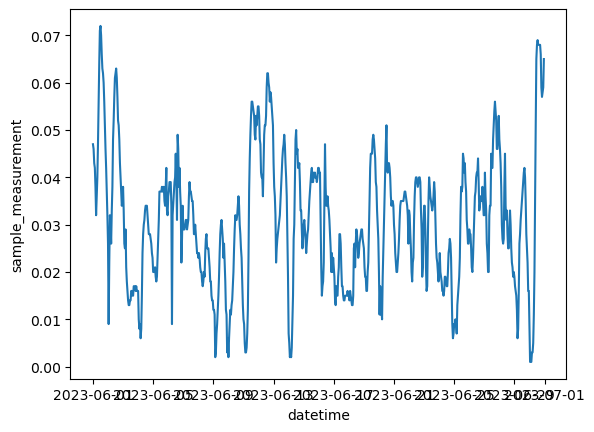

In [22]:
sns.lineplot(x="datetime", y="sample_measurement", data=O3alb)
plt.show()

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    <p>We have a time series! Now let's polish it up a bit...</p>
</div>

2023-06-01 00:00:00
2023-06-30 23:00:00


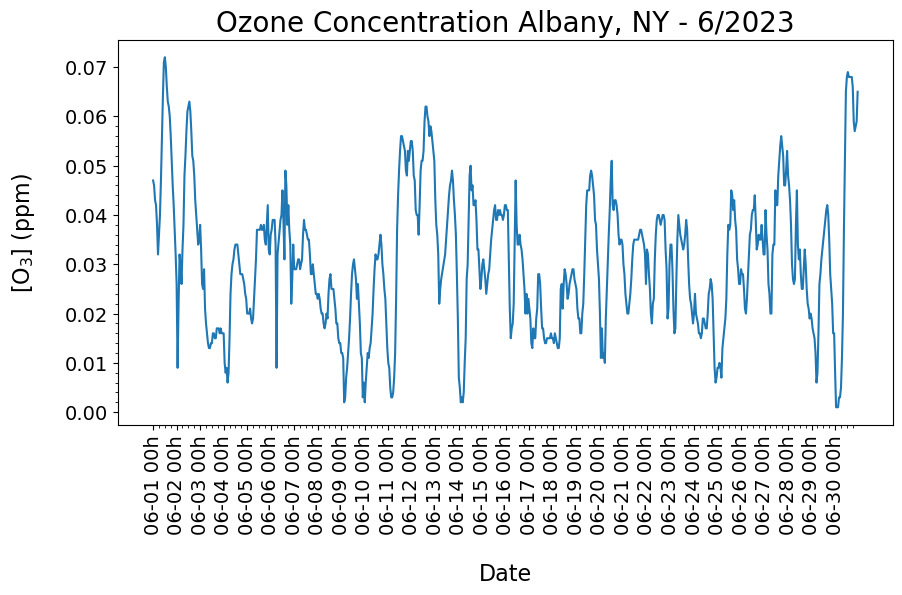

In [23]:
# Design the figure:

# Figure shape
fig, ax = plt.subplots(figsize = (10,5))

# Give it a title
plt.title((f'Ozone Concentration Albany, NY - {month}/{year-1}'), fontsize = 20)

# Plot the data
sns.lineplot(x="datetime", y="sample_measurement", data=O3alb, ax=ax)

# Title the axes
ax.set_xlabel('Date', labelpad = 20, fontsize = 16)
ax.set_ylabel('[O$_{3}$] (ppm)', labelpad = 20, fontsize = 16)

    # For the X-Axis

# Set major x-ticks for midnight (00h)
x_major = O3alb['datetime'][O3alb['datetime'].dt.hour == 0]
ax.set_xticks(x_major)
print(O3alb['datetime'].min())
print(O3alb['datetime'].max())
# Set minor ticks at every 6 hours
x_minor = pd.date_range(start= O3alb['datetime'].min(), end= O3alb['datetime'].max(), freq='6h')
ax.set_xticks(x_minor, minor=True)

# Clean up the date label so it doesn't show the year or minutes
formatted_labels = [x.strftime('%m-%d %H') + 'h' for x in x_major]
ax.set_xticklabels(formatted_labels, rotation=90, fontsize = 14)

    # For the Y-Axis

# Add minor ticks to the y-axis
y_minor = np.arange(0, 0.06, 0.002)
ax.set_yticks(y_minor, minor = True)

# Fix the fontsize for the y-tick labels
ax.tick_params(axis='y', labelsize=14)

plt.show()

We can also add a new data points to compare (e.g., NO<sub>2</sub>)

In [25]:
NO2_data = aqs.bystate.sampledata(parameter= NO2, bdate = date(year=year-1, month=month, day = start), edate = date(year=year-1, month=month, day = end), stateFIPS=NY)

In [26]:
NO2_data['county'].unique()

array(['Erie', 'Bronx', 'Monroe', 'Queens', 'Suffolk'], dtype=object)

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">ALBANY?!</p>
    <p>Albany doesn't seem to display data for NO<sub>2</sub>.</p>
    <p>You're welcome to check on your own for another pollutant to compare, but we'll shift to another county that covers both O<sub>3</sub> and NO<sub>2</sub>.</p>
</div>

In [27]:
ozone['county'].unique()

array(['Monroe', 'Bronx', 'Tompkins', 'Onondaga', 'Chautauqua', 'Niagara',
       'Essex', 'Erie', 'Saratoga', 'Steuben', 'Dutchess', 'Suffolk',
       'Westchester', 'New York', 'Rockland', 'Putnam', 'Hamilton',
       'Wayne', 'Richmond', 'Queens', 'Albany', 'Oswego', 'Jefferson'],
      dtype=object)

The Bronx seems like a good county to work with for the purposes of this Notebook.

In [28]:
bronxNO2 = NO2_data.loc[NO2_data['county'] == 'Bronx', ['date_local', 'time_local', 'sample_measurement', 'units_of_measure', 'site_number', 'latitude', 'longitude']]
bronxO3 = ozone.loc[ozone['county'] == 'Bronx', ['date_local', 'time_local', 'sample_measurement', 'units_of_measure', 'site_number', 'latitude', 'longitude']]

In [29]:
print('O3: ', bronxO3.iloc[0,:], '\n')
print('NO2: ', bronxNO2.iloc[0,:])

O3:  date_local                   2023-06-01
time_local                        00:00
sample_measurement                0.001
units_of_measure      Parts per million
site_number                        0133
latitude                        40.8679
longitude                     -73.87809
Name: 363, dtype: object 

NO2:  date_local                   2023-06-01
time_local                        00:00
sample_measurement                 41.1
units_of_measure      Parts per billion
site_number                        0110
latitude                         40.816
longitude                       -73.902
Name: 144, dtype: object


We've seen that both data are present for Bronx County.

Again, let's make sure our new DataFrames are properly chronological.

In [30]:
bronxO3['datetime'] = pd.to_datetime(bronxO3['date_local'] + ' ' + bronxO3['time_local'])
bronxO3 = bronxO3.sort_values(by='datetime')

bronxNO2['datetime'] = pd.to_datetime(bronxNO2['date_local'] + ' ' + bronxNO2['time_local'])
bronxNO2 = bronxNO2.sort_values(by='datetime')


### Now we'll plot both data together.

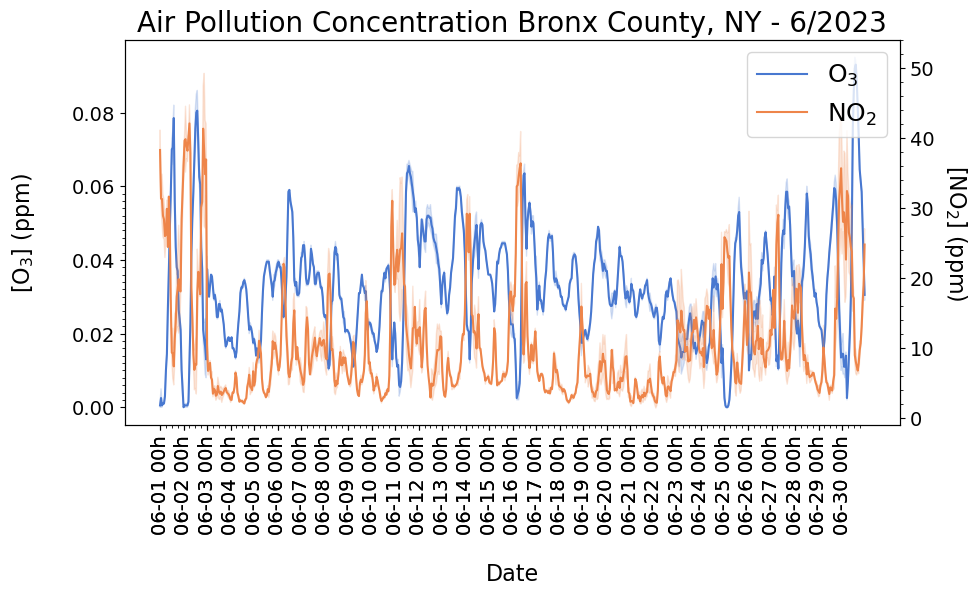

In [31]:
# Design the figure:   
fig, ax = plt.subplots(figsize = (10,5))

shared_colors = sns.color_palette('muted')

# Create a secondary y-axis
ax2 = ax.twinx()

# Give it a title
plt.title((f'Air Pollution Concentration Bronx County, NY - {month}/{year-1}'), fontsize = 20)

# Plot the data for O3
sns.lineplot(x="datetime", y="sample_measurement", data=bronxO3, label = 'O$_{3}$', ax = ax, legend = False, color= shared_colors[0],)

# Plot NO2 data alongside O3 data
sns.lineplot(x="datetime", y="sample_measurement", data=bronxNO2, label='NO$_{2}$', ax = ax2, legend = False, color= shared_colors[1],)


    # For the X-Axis:

# Title the x-axis
ax.set_xlabel('Date', labelpad = 20, fontsize = 16)

# Set major x-ticks for midnight (00h)
x_major = bronxO3['datetime'][bronxO3['datetime'].dt.hour == 0]
ax.set_xticks(x_major)

# Set minor ticks at every 6 hours
x_minor = pd.date_range(start= bronxO3['datetime'].min(), end= bronxO3['datetime'].max(), freq='6h')
ax.set_xticks(x_minor, minor=True)

# Clean up the date label so it doesn't show the year or minutes
formatted_labels = [x.strftime('%m-%d %H') + 'h' for x in x_major]
ax.set_xticklabels(formatted_labels, rotation=90, fontsize = 14)

    # For the Y-Axes:

# Add titles to both y-axes
ax.set_ylabel('[O$_{3}$] (ppm)', labelpad = 25, fontsize = 16)
ax2.set_ylabel('[NO$_{2}$] (ppm)', labelpad=25, fontsize=16, rotation = -90)

# Add minor ticks to the y-axis for O3
y_minor = np.arange(0, 0.06, 0.002)
ax.set_yticks(y_minor, minor = True)

# Fix the fontsize for the y-tick labels
ax.tick_params(axis='y', labelsize=14)

# Add minor ticks to the secondary y-axis for NO2
y2_minor = np.arange(0, 55, 2)
ax2.set_yticks(y2_minor, minor=True)

# Match fontsize for secondary y-axis
ax2.tick_params(axis='y', labelsize=14)

    # Design the legend:

# Combine both plot labels into a single legend
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

plt.legend(handles + handles2, labels + labels2, loc='best', fontsize=18)


plt.show()

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    <p>We've been able to pull data from the AQS and plot a time series!</p>
</div>

---

### Let's take a quick look at how you can pull data based on a areal extent, and then we'll close out this notebook.

#### Let's start with the CONUS

In [32]:
lonW = '-130'
lonE = '-62'
latS = '20'
latN = '55'

In [33]:
CONUS = aqs.bybox.sampledata(parameter= O3, bdate = date(year=year-1, month=month, day = day-1), 
                           edate = date(year=year-1, month=month, day = day), 
                           minlat = latS, maxlat = latN, minlon = lonW, maxlon = lonE)
#CONUS

#### We can also use the extent parameters for New York State.

In [34]:
NY_E = -71
NY_W = -81.0
NY_N = 46
NY_S = 40

In [35]:
NYS = aqs.bybox.sampledata(parameter= O3, bdate = date(year=year-1, month=month, day = day-1), 
                           edate = date(year=year-1, month=month, day = day), 
                           minlat = NY_S, maxlat = NY_N, minlon = NY_W, maxlon = NY_E)
#NYS

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    <p>We've successfully fetched data from the AQS by areal extent for both the CONUS and for NYS!</p>
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">NOTE</p>
    <p>If you want to only use data for within the state, be sure to filter the new DataFrame to ommit data points from other states that cross into the boundaries of your areal extent.</p>
</div>

---

## Summary
In this notebook, we've 
- managed to access air pollution data from the EPA's AQS
- looked at different ways to fetch the data
- looked at different types of data available
- prepared the data for plotting
- generated time series plots of air pollution data
- <b>(... include plotting over a map, direct user to other cookbooks for ideas on interactive visuals?)</b>

<b>You are encouraged to explore other variables within the dataset, and to utilize pandas and numpy functions to look at ways to manipulate and analyze these data!</b>

## Resources and references

Documentation for pyaqsapi: https://usepa.github.io/pyaqsapi/pyaqsapi.html

More information about the pyaqsapi package (developed by [Clinton McCrowey, EPA Region 3](https://github.com/mccroweyclinton-EPA)) can be found on GitHub: https://github.com/USEPA/pyaqsapi

The EPA's AQS has general information and documentation here: https://www.epa.gov/aqs

Details about the specific parameter codes can be found here: https://aqs.epa.gov/aqsweb/documents/codetables/parameters.html

To access real-time data for air pollution, the [AirNow API](https://docs.airnowapi.org/) can be utilized.

Thanks to Daniel Garver (EPA Region 4) for help locating the AQS API, and for directing the authors of this Cookbook to the appropriate resources.

---

<b>Information about the author: [Adam Deitsch](https://amdeitsch.github.io/)</b>